# IEOR 160 HW 4

### Caedi Seim, Tyler Yang

## Imports

In [216]:
#Necessary Librarys for computation 
!pip install cvxpy
!pip install matplotlib
!pip install numpy
!pip install --upgrade pip
!pip install numdifftools

     |████████████████████████████████| 2.1 MB 5.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [217]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import numdifftools as nd

Foreword: While the gradient algorithms usually have a tolerance check to terminate iterations once the solution converges close enough to the optima, our graphs require a certain number of iterations and hence it has been removed from our while loop to prevent early termination and incomplete visuals.

## Problem 1

### CVXpy Optimized solution

In [218]:
#Solution derived using CVX
#initializing the variables to be optimized

opt_x1 = cp.Variable(1)
opt_x2 = cp.Variable(1)
opt_x3 = cp.Variable(1)
term1 = cp.exp(opt_x1 - 1)
term2 = cp.exp(-opt_x1 + 1)
term3 = cp.exp(opt_x2 - 2)
term4 = cp.exp( -opt_x2 + 2)
term5 = cp.exp(opt_x3 - 3)
term6 = cp.exp(-opt_x3 + 3)
term7 = cp.power(opt_x1 + opt_x2 + opt_x3, 4)

objective = term1 + term2 + term3 + term4 + term5 + term6 + term7
problem = cp.Problem(cp.Minimize(objective))
res = problem.solve()
print("x1: {0}\nx2: {1}\nx3: {2}".format(opt_x1.value, opt_x2.value, opt_x3.value))
print("Minimum Value: {0}".format(res))

x1: [-0.64164692]
x2: [0.35835308]
x3: [1.35835307]
Minimum Value: 17.40774602388701


### Gradient Algorithm with Backtracking Line Search

In [219]:

'''
backtracking line search steps:
- fix a parameter beta from 0-1
- start with iteration e = 1
'''
def func(x):
    return (np.exp(x[0] - 1) + np.exp(-x[0] + 1) + np.exp(x[1] - 2) + np.exp(-x[1] + 2)
        + np.exp(x[2] - 3) + np.exp(-x[2] + 3) +  np.power(x[0] + x[1] + x[2], 4))

'''
Initializing variables
'''
delta = 10 ** (-3)
x1, x2, x3 = 0, 0, 0

gradient = nd.Gradient(func)([x1, x2, x3])
#print(type(gradient))
direction = -gradient
beta = 0.5
dpoints = []
dpoints.append([x1, x2, x3])

def backtracking(x1, x2, x3, gradient, delta, direction):
    #when the norm is not close enough to delta continue
    counter = 0
    while np.linalg.norm(nd.Gradient(func)([x1, x2, x3])) > delta and counter < 31:
        counter += 1
        #reset alpha/counter, backtracking line search
        alpha = 1
        while ((func([x1, x2, x3] + alpha * direction)) > (func([x1, x2, x3]))):  
#             print("test")
#             print(alpha * direction)
#             print("____")
#             print([x1, x2, x3] + alpha * direction)
#             print("done")
            alpha = beta * alpha
        
        gradient = nd.Gradient(func)([x1, x2, x3])
        direction = -gradient
        
        #update points
        x1 = x1 + alpha * direction[0]
        x2 = x2 + alpha * direction[1]
        x3 = x3 + alpha * direction[2]
        dpoints.append([x1, x2, x3])
    return dpoints

dpoints = backtracking(x1, x2, x3, gradient, delta, direction)
print("(x1,x2,x3) via gradient alg: ",tuple(dpoints[-1]))

(x1,x2,x3) via gradient alg:  (-0.632445793451641, 0.35315795073881673, 1.3511222890906234)


### Log Linear Plot of Difference Between CVX optima and Gradient Algorithm Solution

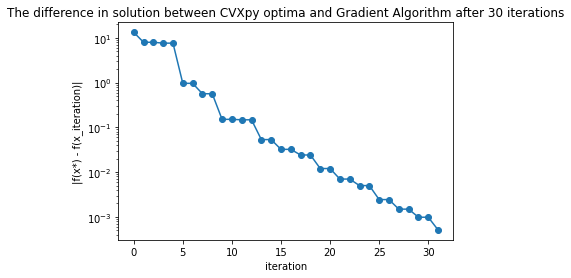

In [220]:
diff = []
def draw(dpoints):
    for i in range(len(dpoints)):
        diff.append(abs(func(dpoints[i]) - func([opt_x1.value, opt_x2.value, opt_x3.value])))
    return diff

draw(dpoints)
plt.yscale("log")
plt.plot(diff, marker="o");
plt.title("The difference in solution between CVXpy optima and Gradient Algorithm after 30 iterations");
plt.ylabel("|f(x*) - f(x_iteration)|");
plt.xlabel("iteration");

### Trajectory Plot of Gradient Algorithm

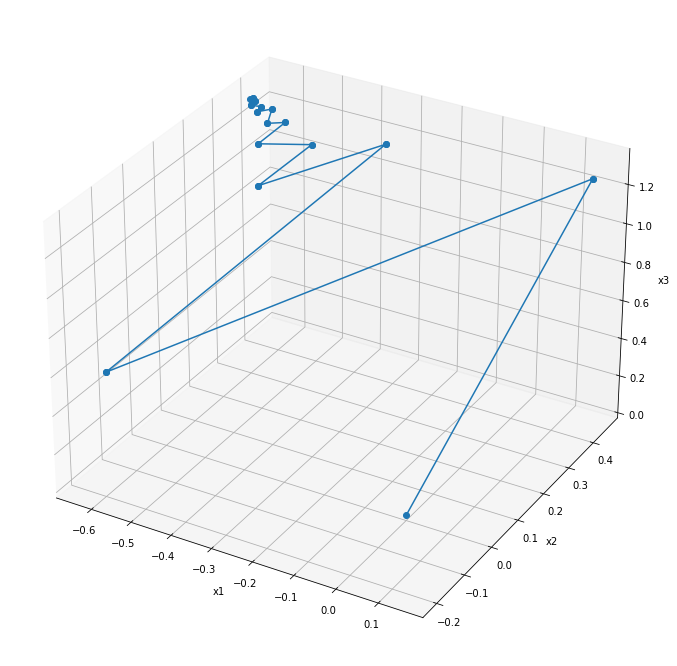

In [221]:
#plot for the 3d plot
splitted = list(zip(*dpoints))
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
# for i in range(len(splitted[0])):|
#     ax.quiver(0, 0, 0, splitted[0][i], splitted[1][i], splitted[2][i])
ax.plot(splitted[0], splitted[1], splitted[2], marker = "o")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3");

## Problem 2

### Newton's Algorithm with Backtracking Line Search

In [222]:
delta = 10 ** (-3)
x1, x2, x3 = 0, 0, 0
gradient = nd.Gradient(func)([x1, x2, x3])
hessian = nd.Hessian(func)([x1, x2, x3])
direction = - 1 * np.linalg.inv(hessian) @ gradient.T
beta = 0.5
dpoints = []
dpoints.append([x1, x2, x3])
def newtonWithBacktracking(x1, x2, x3, gradient, delta, direction):
    counter = 0
    while counter < 30:
        counter += 1
        alpha = 1
        while ((func([x1, x2, x3] + alpha * direction)) > (func([x1, x2, x3]))):  
            alpha = beta * alpha
        
        gradient = nd.Gradient(func)([x1, x2, x3])
        hess = nd.Hessian(func)([x1,x2, x3])
        direction =  -1 * np.linalg.inv(hess) @ gradient.T
        
        x1 = x1 + alpha * direction[0]
        x2 = x2 + alpha * direction[1]
        x3 = x3 + alpha * direction[2]
        dpoints.append([x1, x2, x3])
    return dpoints

dpoints = newtonWithBacktracking(x1, x2, x3, gradient, delta, direction)
print("optima found via newton's method: ")
print("x1: {0}\nx2: {1}\nx3:{2}\n".format(dpoints[-1][0], dpoints[-1][1], dpoints[-1][2]))
diff = []

optima found via newton's method: 
x1: -0.6416469888271722
x2: 0.35835301117283636
x3:1.3583530111726467



### Log Linear Plot of Difference Between CVX optima and Newton's Algorithm Solution

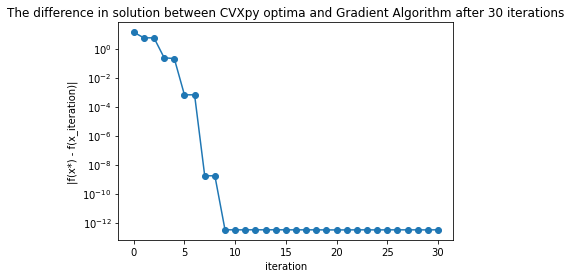

In [223]:
def draw(dpoints):
    for i in range(len(dpoints)):
        diff.append(abs(func(dpoints[i]) - func([opt_x1.value, opt_x2.value, opt_x3.value])))
    return diff

draw(dpoints)
plt.yscale("log")
plt.plot(diff, marker="o");
plt.title("The difference in solution between CVXpy optima and Gradient Algorithm after 30 iterations");
plt.ylabel("|f(x*) - f(x_iteration)|");
plt.xlabel("iteration");

### Trajectory Plot of Newton's Algorithm

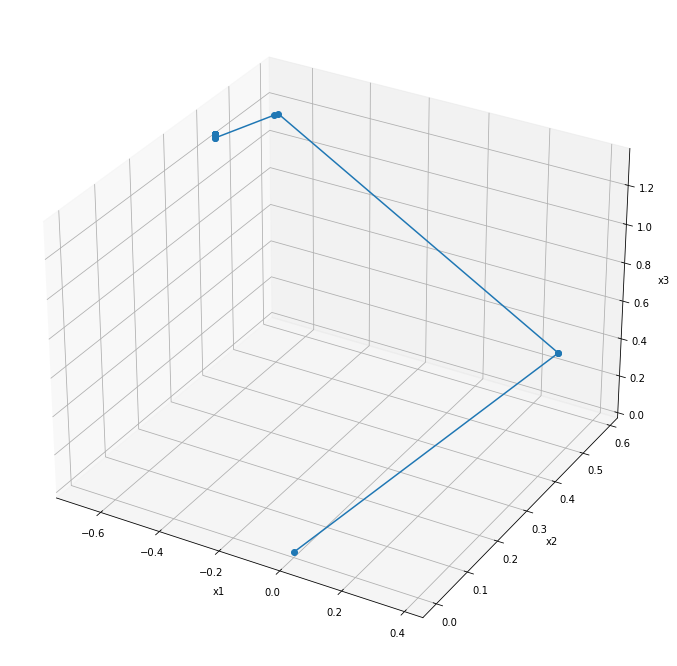

In [224]:
#plot for the 3d plot
splitted = list(zip(*dpoints))
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.plot(splitted[0], splitted[1], splitted[2], marker="o")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3");